In [ ]:
!pip install dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 11.9 MB/s eta 0:00:00


In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings (action='ignore', category=DataConversionWarning)
warnings.filterwarnings (action='ignore', category=ConvergenceWarning)
warnings.filterwarnings (action='ignore', category=UserWarning)
#!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset=pd.read_csv('hotels.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
# Total stay in nights
dataset['total_stay'] = dataset ['stays_in_week_nights']+dataset ['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset ['adults']+dataset ['children'] +dataset ['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned' ]=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices, 'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights', 'stays_in_weekend_nights', 'adults', 'children', 'babies'
, 'reserved_room_type', 'assigned_room_type'], axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [ ]:
dataset.isnull().sum() # Country, Agent, Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent', 'company'], axis=1)
# Replacing missing countries with most freqently occuring countries
dataset ['country'] = dataset ['country'].fillna (dataset ['country'].mode()[0])

In [ ]:
dataset = dataset.drop(['reservation_status', 'reservation_status_date', 'arrival_date_day_of_month'], axis=1)
dataset = dataset.drop(['arrival_date_year'], axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

In [ ]:
#Replacing 1 by True and by False for the experiment and outcome variables
dataset ['different_room_assigned'] = dataset [ 'different_room_assigned'].replace (1, True)
dataset ['different_room_assigned'] = dataset [ 'different_room_assigned'].replace(0, False)
dataset['is_canceled'] = dataset ['is_canceled'].replace(1, True)
dataset ['is_canceled'] = dataset ['is_canceled'].replace(0, False)
dataset.dropna (inplace=True)

In [ ]:
dataset.iloc[:,5:20].head(100)

,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,73.80,0,1,2,2.0
96,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,117.00,0,1,7,2.0
97,HB,ESP,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0,1,7,3.0
98,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,99.30,1,2,7,3.0


In [ ]:
dataset = dataset [dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type', 'is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29690      29690               29690   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29690  29690    29690   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29690              29690   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29690   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29690            29690   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29690          29690  29690   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29690   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29690       29690   29690   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29690

In [ ]:
dataset_copy = dataset.copy(deep=True)

**Calculating Expected Counts**

Since the number of number of cancellations and the number of times a different room was assigned is heavily imbalanced, we first choose
1000 observations at random to see that in how many cases do the variables; 'is_cancelled' & 'different_room_assigned' attain the same values.
This whole process is then repeated 10000 times and the expected count turns out to be near 50% (i.e. the probability of these two variables
attaining the same value at random). So statistically speaking, we have no definite conclusion at this stage. Thus assigning rooms different to
what a customer had reserved during his booking earlier, may or may not lead to him/her cancelling that booking.

In [ ]:
counts_sum=0
for i in range (1,10000):
  counts_i = 0
  rdf = dataset. sample (1000)
  counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
  counts_sum+= counts_i
counts_sum/10000

588.7218

In [ ]:
!apt-get install graphviz graphviz-dev
!pip install pygraphviz
import pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jamm

In [ ]:
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders", observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned, required_car_parking_spaces, guests, total_stay, total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled, different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned; is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> {different_room_assigned, is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes, is_canceled};
country->{hotel, required_car_parking_spaces, total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces, total_of_special_requests};
}"""

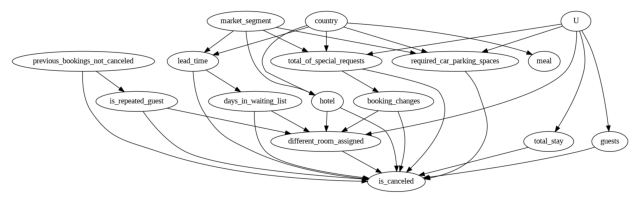

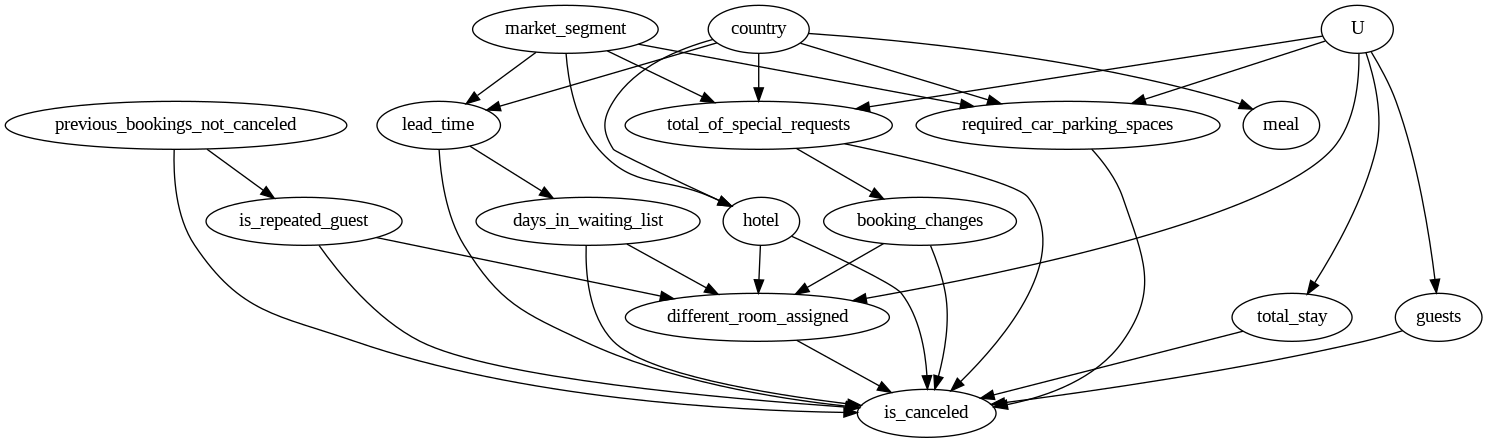

In [ ]:
model=dowhy.CausalModel(
data = dataset,
graph=causal_graph.replace("\n"," "),
treatment="different_room_assigned",
outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display (Image(filename="causal_model.png"))

In [ ]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|total_of_special_requests,booking_cha
d[different_room_assigned]                                                    

                                                                              
nges,required_car_parking_spaces,lead_time,is_repeated_guest,days_in_waiting_l
                                                                              

                             
ist,hotel,guests,total_stay])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_of_special_requests,booking_changes,required_car_parking_spaces,lead_time,is_repeated_guest,days_in_waiting_list,hotel,guests,total_stay,U) = P(is_canceled|different_room_assigned,total_

In [ ]:
estimate = model.estimate_effect (identified_estimand,
method_name="backdoor.propensity_score_weighting", target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|total_of_special_requests,booking_cha
d[different_room_assigned]                                                    

                                                                              
nges,required_car_parking_spaces,lead_time,is_repeated_guest,days_in_waiting_l
                                                                              

                             
ist,hotel,guests,total_stay])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_of_special_requests,booking_changes,required_car_parking_spaces,lead_time,is_repeated_guest,days_in_waiting_list,hotel,guests,total_stay,U

In [ ]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Add a random common cause
Estimated effect:-0.26214429384412213
New effect:-0.2621442938441222
p value:1.0



In [ ]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
print(res_placebo)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a Placebo Treatment
Estimated effect:-0.26214429384412213
New effect:0.05531032223746402
p value:0.0



In [ ]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a subset of data
Estimated effect:-0.26214429384412213
New effect:-0.2620940525226674
p value:0.8400000000000001

